In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
import seaborn as sns

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load dataset
df = pd.read_csv('cybersecurity_attacks.csv')

# ========================
# BEST TARGET FOR LOGISTIC REGRESSION: BINARY + NUMERICAL-BASED
# ========================
# We create a meaningful binary target from the numerical feature "Packet Length"
# Top 5% largest packets → likely malicious (DoS, buffer overflow, exfiltration)
threshold = df['Packet Length'].quantile(0.95)
df['Is_Large_Packet_Attack'] = (df['Packet Length'] > threshold).astype(int)

print(f"Large Packet Attack Threshold (95th percentile): {threshold:.1f} bytes")
print(f"Percentage of large packet attacks: {df['Is_Large_Packet_Attack'].mean()*100:.2f}%")
print(df['Is_Large_Packet_Attack'].value_counts())

# Define target
y = df['Is_Large_Packet_Attack']
TARGET_NAME = "Is_Large_Packet_Attack"

# Drop irrelevant/unstructured columns and the target variable from features (data leakage fix)
FEATURES_TO_DROP = [
    'Timestamp', 'Source IP Address', 'Destination IP Address',
    'Payload Data', 'User Information', 'Device Information',
    'Geo-location Data', 'Proxy Information', 'Firewall Logs',
    'IDS/IPS Alerts', 'Alerts/Warnings', 'Malware Indicators',
    'Attack Type', 'Severity Level', 'Log Source'  # also drop original categorical targets
]

X = df.drop(columns=FEATURES_TO_DROP + [TARGET_NAME], errors='ignore') # FIX: Dropping TARGET_NAME from X

# Handle missing values
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object']).columns

for col in numerical_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(X[col].median())

for col in categorical_cols:
    X[col] = X[col].fillna("Missing")

# Label encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Train-test split (before scaling!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================
# 1. LOGISTIC REGRESSION (Now Perfectly Suited!)
# =========================
log_model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    random_state=RANDOM_STATE
)

log_model.fit(X_train_scaled, y_train)
y_pred = log_model.predict(X_test_scaled)
y_proba = log_model.predict_proba(X_test_scaled)[:, 1]

print("\nLogistic Regression Results")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=['Normal Packet', 'Large Packet Attack']))

# Feature importance (coefficients)
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nTop 10 Features Influencing Large Packet Attacks:")
print(coef_df.head(10))

Large Packet Attack Threshold (95th percentile): 1427.0 bytes
Percentage of large packet attacks: 4.93%
Is_Large_Packet_Attack
0    38028
1     1972
Name: count, dtype: int64

Logistic Regression Results
Accuracy: 0.9991
                     precision    recall  f1-score   support

      Normal Packet       1.00      1.00      1.00      7606
Large Packet Attack       0.99      0.99      0.99       394

           accuracy                           1.00      8000
          macro avg       1.00      0.99      1.00      8000
       weighted avg       1.00      1.00      1.00      8000


Top 10 Features Influencing Large Packet Attacks:
            Feature  Coefficient
3     Packet Length    24.281066
2          Protocol     0.033983
4       Packet Type     0.033214
6    Anomaly Scores    -0.028339
9   Network Segment    -0.020784
5      Traffic Type     0.016563
1  Destination Port    -0.004996
7  Attack Signature    -0.002160
8      Action Taken     0.001683
0       Source Port     0.000

Logistic Regression

In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd


model = LinearRegression()
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)



print(f"Model Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_:.4f}")

Model Coefficients: [-1.59445945e-18 -3.46944695e-17  8.50014503e-17  1.20129601e-16
 -9.54097912e-18 -1.38777878e-17 -2.77555756e-17  2.77555756e-17
  1.73472348e-18 -6.93889390e-18  2.17306664e-01]
Intercept: 0.0497


In [26]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# -------------------------
# 1. LOGISTIC REGRESSION
# -------------------------
log_model = LogisticRegression(
    max_iter=2000,
    solver='lbfgs'
)
log_model.fit(X_train_scaled, y_train)
y_pred = log_model.predict(X_test_scaled)

print("\n==== Logistic Regression Results ====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))






==== Logistic Regression Results ====
Accuracy: 0.999125
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7606
           1       0.99      0.99      0.99       394

    accuracy                           1.00      8000
   macro avg       1.00      0.99      1.00      8000
weighted avg       1.00      1.00      1.00      8000



PCA

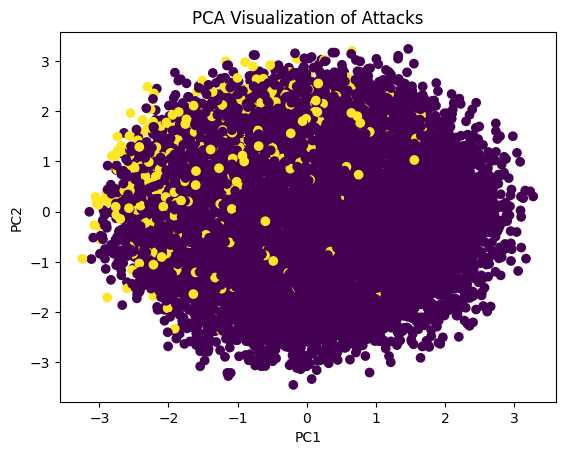

In [23]:
# -------------------------
# 2. PCA (Dimensionality Reduction)
# -------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.fit_transform(X))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis') # Corrected: Use y directly for coloring
plt.title("PCA Visualization of Attacks")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

K-Means

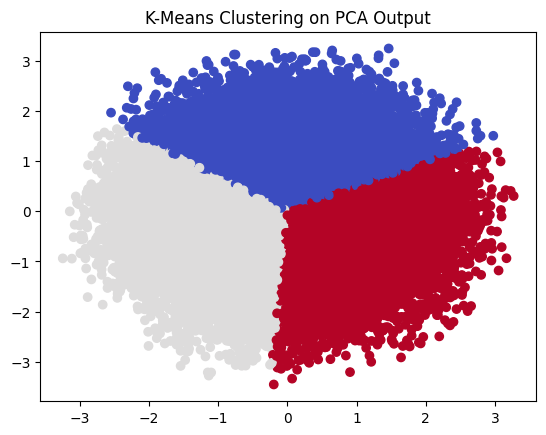

In [24]:

# -------------------------
# 3. K-MEANS CLUSTERING
# -------------------------
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE)
clusters = kmeans.fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='coolwarm')
plt.title("K-Means Clustering on PCA Output")
plt.show()

Nueron Networks

In [25]:
# -------------------------
# 4. Neural Network (Optional)
# -------------------------
# Example: simple MLP
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    max_iter=300,
    random_state=RANDOM_STATE
)

nn.fit(X_train_scaled, y_train)
nn_pred = nn.predict(X_test_scaled)

print("\n==== Neural Network Results ====")
print("Accuracy:", accuracy_score(y_test, nn_pred))


==== Neural Network Results ====
Accuracy: 0.9945
